## Análise Estatística Descritiva e Inferencial da Sincronização de Tempo em Redes Locais Usando LinuxPTP

A sincronização precisa de tempo em redes de computadores é fundamental para diversas aplicações, incluindo redes industriais, telecomunicações e data centers. Neste trabalho, utilizamos o [LinuxPTP](https://linuxptp.sourceforge.net/), uma implementação do [**Precision Time Protocol (PTP)**](https://endruntechnologies.com/pdf/PTP-1588.pdf), para simular e analisar a sincronização de tempo entre diferentes nós de uma rede. O LinuxPTP oferece uma maneira robusta de sincronizar relógios em diferentes dispositivos numa LAN, permitindo atingir precisões na ordem de microssegundos ou até nanosegundos, dependendo das condições da rede e do hardware disponível.

A análise deste trabalho é feita utilizando **Estatística Descritiva e Inferencial**, com a aplicação de **testes de hipóteses** para avaliar o comportamento da sincronização em diferentes cenários. Para isso, configuramos nós em uma rede local que atuam como mestres e escravos PTP, e coletamos dados de _**Time offset**_ durante a sincronização.

Os principais objetivos deste trabalho incluem:

- **$I.$ Testar Timestamping em Software vs. Hardware**: Comparar a eficácia da sincronização utilizando **timestamping em software** e **timestamping em hardware**.

- **Avaliar a Qualidade da Sincronização**: Examinar se o **offset** entre o mestre e o escravo se mantém próximo de zero em diferentes condições de rede.

- **Comparar Topologias de Sincronização**: Verificar a eficácia de diferentes configurações, como topologias **mestre-escravo** simples e aquelas que envolvem **_Transparent Clocks_** ou **_Boundary Clocks_**.



## Ambiente de testes

Para este estudo, utilizamos 3 computadores cuja as especificações são descritas na tabela abaixo:

| Especificação      | PC 1 (jv3301)                | PC 2 (Vostro-3470)               | PC 3 (lasse100)                      |
|--------------------|---------------------------------|--------------------------------------------|-----------------------------------------|
| OS                 | Ubuntu 22.04.5 LTS x86_64       | Ubuntu 22.04.4 LTS x86_64                  | Ubuntu 18.04.4 LTS x86_64               |
| Kernel             | 6.8.0-45-generic                | 6.5.0-35-generic                           | 4.15.0-213-generic                      |
| NIC                 | Intel X550-T2 PCI-E X4         | Intel X550-T2 PCI-E X4                     | Intel X550-T2 PCI-E X4      |
| CPU                | Intel i5-7600 (4) @ 4.10GHz     | Intel i5-9400 (6) @ 4.10GHz                | Intel i7-5930K (12) @ 3.700GHz          |
| GPU                | Intel HD Graphics 630           | Intel HD Graphics 630  | AMD Radeon HD 7770/8760                 |
| Memory             | 8GB                 | 16GB                           | 64GB                        |



Os dados são coletados diretamente dos logs do **ptp4l**, a ferramenta do LinuxPTP que executa a sincronização. 


## Linux PTP

O [LinuxPTP](https://linuxptp.sourceforge.net/) é uma implementação do Precision Time Protocol (PTP), conforme definido pelo padrão [**IEEE 1588**](https://endruntechnologies.com/pdf/PTP-1588.pdf). O PTP é um protocolo de rede utilizado para sincronizar relógios em sistemas de computadores distribuídos através de uma rede local (LAN).

Componentes Principais:

- ptp4l: O daemon principal do LinuxPTP, responsável por implementar o protocolo PTP e gerenciar a sincronização de tempo entre os dispositivos.
- phc2sys: Uma ferramenta auxiliar que sincroniza o relógio de hardware do PTP (PHC) com o relógio do sistema, garantindo que ambos permaneçam alinhados.

<div style="text-align: center;">
    <img src="./assets/HS.png" width="840" height="480" allow="autoplay"></iframe>
</div>

## $I$. Software Timestamping Vs. Hardware Timestamping

Para a primeira análise inferencial vamos comparar o sincronismo utilizando Software Timestamping Vs. Hardware Timestamping. 

- Software timestamping é o processo de marcar o tempo de eventos diretamente no software. Isso geralmente é feito no nível da aplicação ou do sistema operacional. A precisão do timestamp depende da carga do sistema e da latência do software, o que pode introduzir variações e atrasos.

- Hardware timestamping, por outro lado, envolve a marcação de tempo diretamente no hardware de rede, como em placas de rede (NICs). Isso permite uma precisão muito maior, pois os timestamps são gerados no momento exato em que os pacotes são enviados ou recebidos, minimizando a latência e a variação introduzida pelo software.

Nas imagens abaixo podemos ver onde cada tipo de timestamping atua na camada de pilhas e a topologia usada para essa primeira comparação: 

<div style="text-align: center;">
    <img src="./assets/ptp-hardware-software-based-timestamp.png" width="640" height="480" allow="autoplay"></iframe>
    <img src="./assets/topo1.png" width="640" height="480" allow="autoplay"></iframe>
</div>

A segunda imagem ilustra uma topologia de rede ponto a ponto, composta por dois computadores: PC 1 (servidor "Master") e PC 2 (servidor "Slave"). Esses dispositivos estão conectados diretamente por um link físico, representado pela linha azul, sem outros dispositivos de rede intermediários. Ambos os PCs possuem placas de interface de rede Intel X550-T2 PCI-E X4, que são usadas para estabelecer a comunicação direta.

Para realizar os testes de sincronização de tempo, configuramos o PC 1 como o mestre executando o comando `ptp4l`, enquanto o PC 2 foi definido como escravo também utilizando `ptp4l`. Em ambos os PCs, o log da execução foi redirecionado para um arquivo de texto, registrando dados por um período de 5 minutos. 

O período de coleta de dados foi relativamente curto, pois, como se trata de uma conexão ponto a ponto sem tráfego de fundo ("background traffic"), acreditamos que a sincronização seguirá uma tendência constante, devido à ausência de interferências externas ou congestionamento que poderiam introduzir variações significativas.

Fizemms esses mesmos passos testando ambas as formas de timestamping.

Abaixo, realizamos o carregamento e processamento dos logs de PTP para extrair informações de time offset e frequency offset, a fim de armazenar esses dados em DataFrames para posterior análise e visualização.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from log_processing import process_log_file
from plotting import plot_graphs
import numpy as np
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, stats


# Padroes de time e freq
offset_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+(-?\d+)'
freq_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+-?\d+ s2 freq\s+(-?\d+)'

log_files = ['logs/Soft.txt', 'logs/Hard.txt'] # Arquivos de texto contendo o log extraido do ptp4l.

# Soft.txt -> log da sincronização usando software timestamping.
# Hard.txt -> log da sincronização usando hardware timestamping.

dataframes = {}

for log_file in log_files:
    dataframes[log_file] = process_log_file(log_file, offset_pattern, freq_pattern)

Dados a leitura e o processamento, agora podemos visualizar os dados de Software e Hardware timestamping 

- ### Dados do sincronismo usando software timestamping



In [4]:
df_s_log = dataframes['logs/Soft.txt'] # dataframe da sincronização usando software timestamping.
df_s_log.describe()

,elapsed_time,offset,frequency,seconds
count,312.000000,312.000000,291.000000,312.000000
mean,14419.287776,-395.070513,-9318.202749,155.981776
std,90.652489,73829.599313,2086.863093,90.652489
min,14263.306000,-395149.000000,-23638.000000,0.000000
25%,14341.065000,3997.250000,-9487.500000,77.759000
50%,14418.823000,9868.000000,-9189.000000,155.517000
75%,14497.581250,20932.250000,-8827.000000,234.275250
max,14575.340000,171637.000000,-917.000000,312.034000


Durante a sincronização evidenciamos que os primeiros momentos se dedicam a estabilização das medidas, por conta disso as primeiras linhas do log nos fornecem medidas bem ruins. Isso enquadra essas medidas como outliers e atrapalham a visualização dos dados gerais. Por isso, faz-se necessária a remoção desses outliers na célula de código abaixo:

In [5]:
# Selecionar o DataFrame
df_s_log = dataframes['logs/Soft.txt']

df_s_log = df_s_log[(df_s_log['offset'] >= -80000) & (df_s_log['offset'] <= 80000)]

dataframes['logs/Soft.txt'] = df_s_log

df_s_log.describe()

,elapsed_time,offset,frequency,seconds
count,284.000000,284.000000,284.000000,284.000000
mean,14431.729292,13058.426056,-9327.161972,168.423292
std,83.441123,19716.930080,1654.016549,83.441123
min,14280.308000,-75648.000000,-20740.000000,17.002000
25%,14360.067000,4692.500000,-9485.750000,96.761000
50%,14431.824000,10241.000000,-9194.500000,168.518000
75%,14504.582000,20623.500000,-8833.500000,241.276000
max,14575.340000,76842.000000,-5619.000000,312.034000


Acima obtemos o dataset ja filtrado.

- ### Dados do sincronismo usando hardware timestamping

In [6]:
df_h_log = dataframes['logs/Hard.txt'] # dataframe da sincronização usando hardware timestamping.
df_h_log.describe()

,elapsed_time,offset,frequency,seconds
count,313.000000,313.000000,147.000000,313.000000
mean,1149.014217,-398.865815,-4.088435,156.014217
std,90.508826,4982.937770,4.453604,90.508826
min,993.000000,-62438.000000,-16.000000,0.000000
25%,1071.006000,-3.000000,-8.000000,78.006000
50%,1149.014000,-1.000000,-2.000000,156.014000
75%,1227.022000,4.000000,-1.000000,234.022000
max,1305.031000,21.000000,0.000000,312.031000


Durante a sincronização evidenciamos que os primeiros momentos se dedicam a estabilização das medidas, por conta disso as primeiras linhas do log nos fornecem medidas bem ruins. Isso enquadra essas medidas como outliers e atrapalham a visualização dos dados gerais. Por isso, faz-se necessária a remoção desses outliers na célula de código abaixo:

In [7]:
# Selecionar o DataFrame
df_h_log = dataframes['logs/Hard.txt']

# Remover os primeiros 2 registros
df_h_log = df_h_log.iloc[2:]
dataframes['logs/Hard.txt'] = df_h_log

df_h_log.describe()

,elapsed_time,offset,frequency,seconds
count,311.000000,311.000000,147.000000,311.000000
mean,1150.014309,0.090032,-4.088435,157.014309
std,89.931436,8.032892,4.453604,89.931436
min,995.000000,-18.000000,-16.000000,2.000000
25%,1072.506000,-3.000000,-8.000000,79.506000
50%,1150.014000,-1.000000,-2.000000,157.014000
75%,1227.522000,4.000000,-1.000000,234.522000
max,1305.031000,21.000000,0.000000,312.031000


Com os dados já filtrados podemos comparar as duas sincronizações:

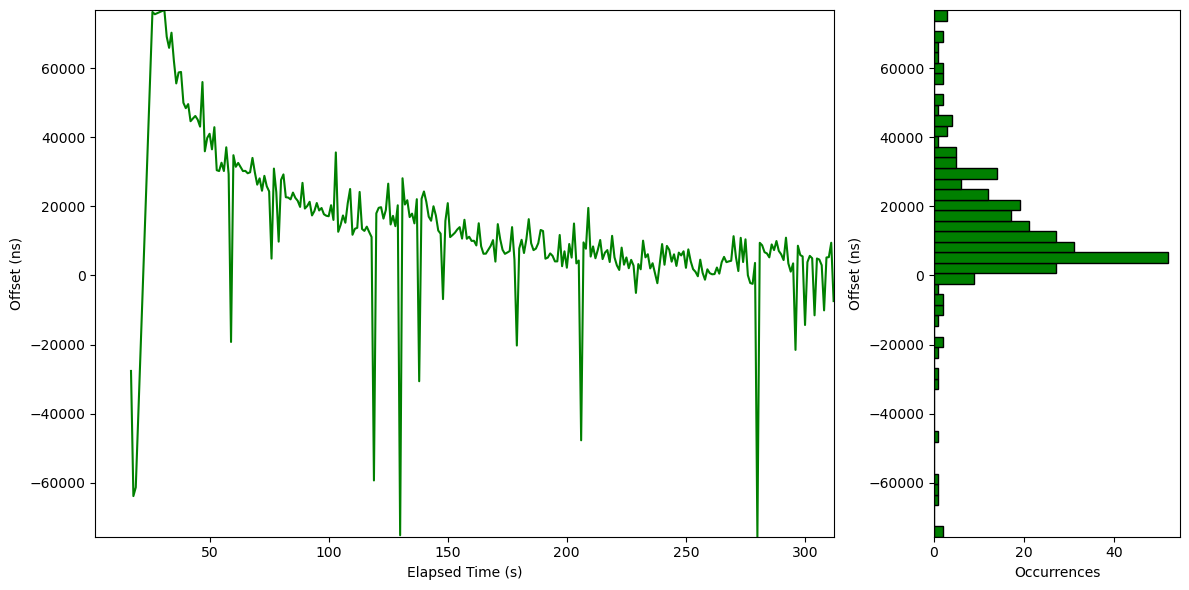

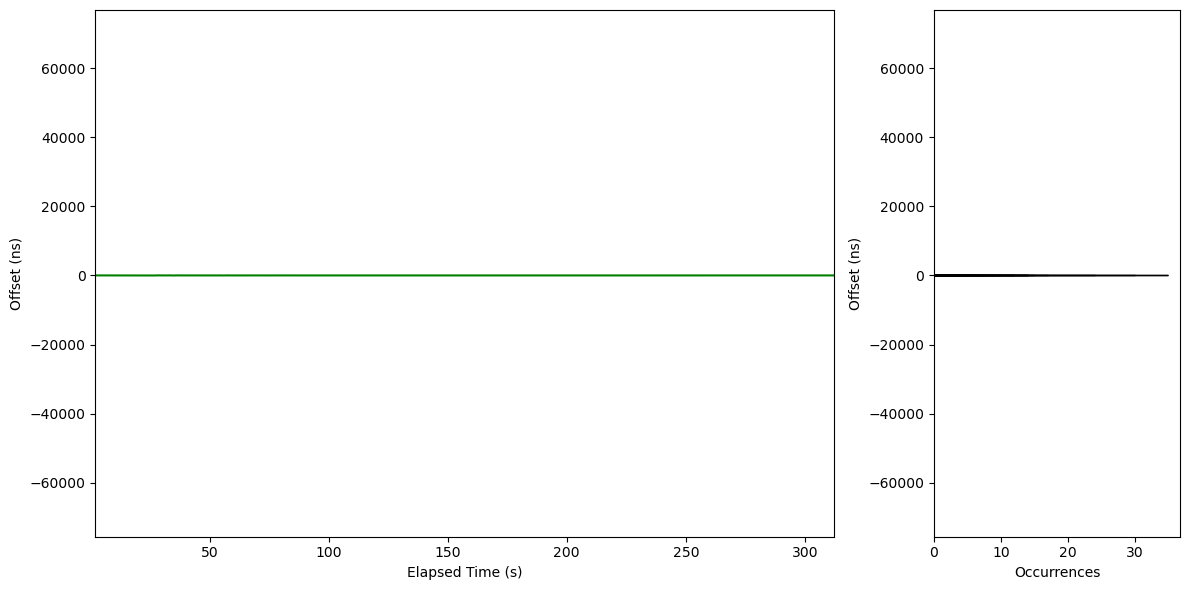

In [8]:
plot_graphs(log_files, dataframes, 'Offset (ns)', 'offset_results', 'green')

Como a função que criamos deixa os plots no range do dataset de maior variação a fim de fazer as comparações torna-se inviável visualizar o segundo conjunto de plots, por isso abaixo fazemos o plot isolado. 

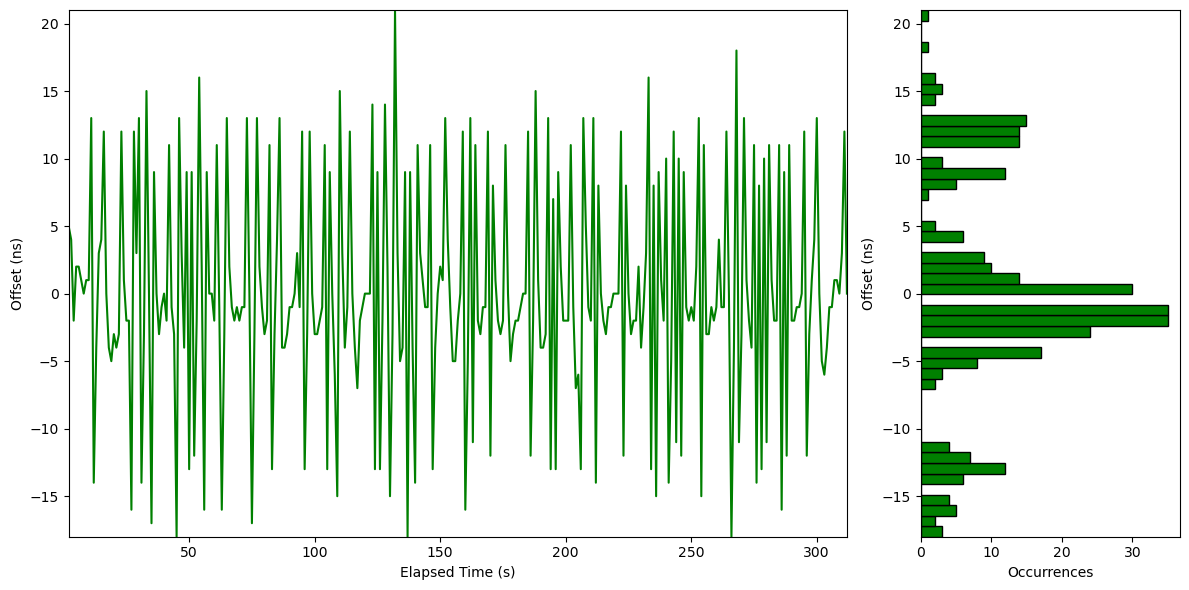

In [16]:
plot_graphs(log_files, dataframes, 'Offset (ns)', 'offset_results', 'green','logs/Hard.txt')


Visualmente ja podemos vislumbrar a superioridade de precisão do Hardware Timestamping, para confirmar essa impressão realizaremos a seguir o teste de hipótese, mas antes iremos verificar se os dados em questão seguem uma distribuição nomral para definir qual teste é adequado. 

Hardware timestamping - Shapiro-Wilk test:
Statistic: 0.9469967270243043, p-value: 3.843430916728075e-09

Software timestamping - Shapiro-Wilk test:
Statistic: 0.8556927006469384, p-value: 1.3241972226190612e-15

Os dados de hardware timestamping não são normalmente distribuídos.
Os dados de software timestamping não são normalmente distribuídos.


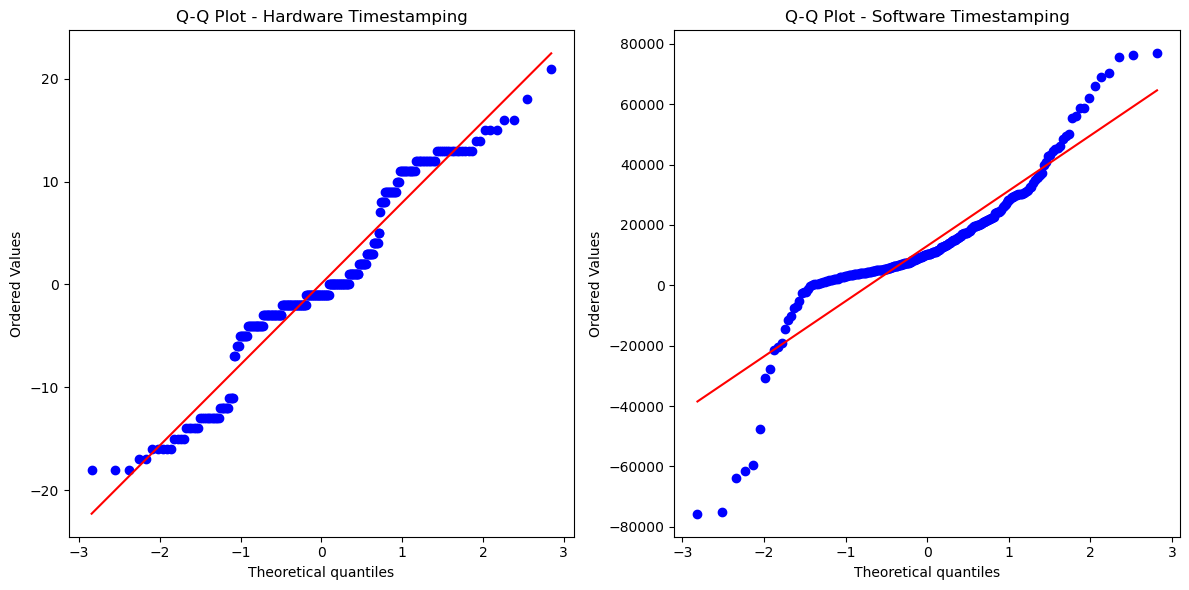

In [25]:
offsets_hardware = df_h_log['offset']
offsets_software = df_s_log['offset']

# Teste de Shapiro
shapiro_hardware = shapiro(offsets_hardware)
shapiro_software = shapiro(offsets_software)

print("Hardware timestamping - Shapiro-Wilk test:")
print(f"Statistic: {shapiro_hardware.statistic}, p-value: {shapiro_hardware.pvalue}")

print("\nSoftware timestamping - Shapiro-Wilk test:")
print(f"Statistic: {shapiro_software.statistic}, p-value: {shapiro_software.pvalue}")

alpha = 0.05
if shapiro_hardware.pvalue < alpha:
    print("\nOs dados de hardware timestamping não são normalmente distribuídos.")
else:
    print("\nOs dados de hardware timestamping são normalmente distribuídos.")

if shapiro_software.pvalue < alpha:
    print("Os dados de software timestamping não são normalmente distribuídos.")
else:
    print("Os dados de software timestamping são normalmente distribuídos.")

# Q-Q Plot para visualização
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(offsets_hardware, dist="norm", plot=plt)
plt.title('Q-Q Plot - Hardware Timestamping')

plt.subplot(1, 2, 2)
stats.probplot(offsets_software, dist="norm", plot=plt)
plt.title('Q-Q Plot - Software Timestamping')

plt.tight_layout()
plt.show()


Como os dados não seguem uma distribuição normal e as amostras são independentes optammos por usar o teste não parametrico de Mann-Whitney U com as seguintes hipóteses:

- Hipótese Nula (H0): As duas amostras vêm da mesma distribuição ou têm medianas iguais.

- Hipótese Alternativa (H1): Existe uma diferença significativa entre as duas amostras

In [26]:
u_stat, p_value = mannwhitneyu(offsets_hardware, offsets_software, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula: Há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.")
else:
    print("Falhamos em rejeitar a hipótese nula: Não há evidência suficiente para afirmar que há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.")


U-statistic: 6842.0
P-value: 4.557987158823712e-71
Rejeitamos a hipótese nula: Há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.


Como esperado, o teste inferencial corrobou com a impressão descritiva e podemos afirmar que há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping, sendo o hardware timestamping mais eficaz e preciso.